In [1]:
from ott.neural.flows.models import VelocityField
from ott.neural.flows.flows import ConstantNoiseFlow
from ott.neural.flows.samplers import sample_uniformly
from ott.neural.flows.otfm import OTFlowMatching
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud
from ott.neural.data.dataloaders import OTDataLoader

import optax
import scanpy as sc
import anndata as ad

import jax.numpy as jnp
import cloudpickle
import jax

import numpy as np
import pandas as pd

In [52]:
adata = sc.read_h5ad('scvi_adata_32x_hidden_500k.h5ad')
adata

AnnData object with n_obs × n_vars = 500000 × 2000
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'batch', 'cell_cluster', 'celltype', 'cellcluster_moscot', '_scvi_batch', '_scvi_labels'
    var: 'gene_type', 'celltype', 'chr'
    obsm: 'X_emb'

In [53]:
adata.obs.day = [float(x[1:]) for x in adata.obs.day]

In [54]:
#adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/training/100k/2k_genes/integrated_adata.h5ad')

adata_loader = OTDataLoader(1024, source_lin=adata[adata.obs['day']==10.25].obsm['X_emb'], target_lin=adata[adata.obs['day']==10.5].obsm['X_emb'])

neural_vf = VelocityField(
    output_dim=50,
    condition_dim=0,
    latent_embed_dim=256,
    n_frequencies=128
)
ot_solver = sinkhorn.Sinkhorn()
time_sampler = sample_uniformly
optimizer = optax.adam(learning_rate=1e-4)
fm = OTFlowMatching(
    neural_vf,
    input_dim=50,
    cond_dim=0,
    iterations=500,
    valid_freq=2,
    ot_solver=ot_solver,
    flow=ConstantNoiseFlow(1.0),
    time_sampler=time_sampler,
    optimizer=optimizer
)
fm(adata_loader, adata_loader)

In [55]:
result_forward = fm.transport(jnp.array(adata[adata.obs['day']==10.25].obsm['X_emb']), condition=None, forward=True)
tmp = ad.AnnData(np.array(result_forward))
tmp.obs['day'] = adata[adata.obs['day']==10.25].obs.day.values
tmp

AnnData object with n_obs × n_vars = 11912 × 50
    obs: 'day'

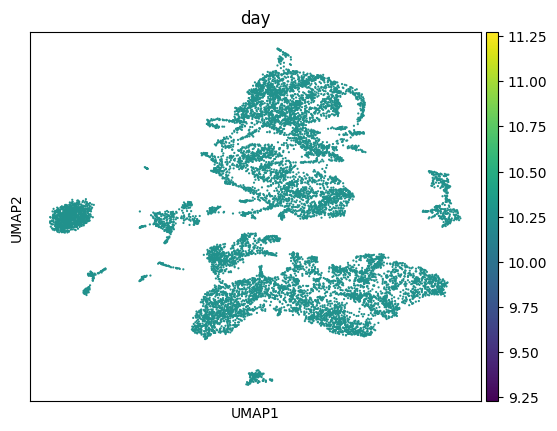

In [56]:
sc.pp.neighbors(tmp)
sc.tl.umap(tmp)
sc.pl.umap(tmp, color='day')

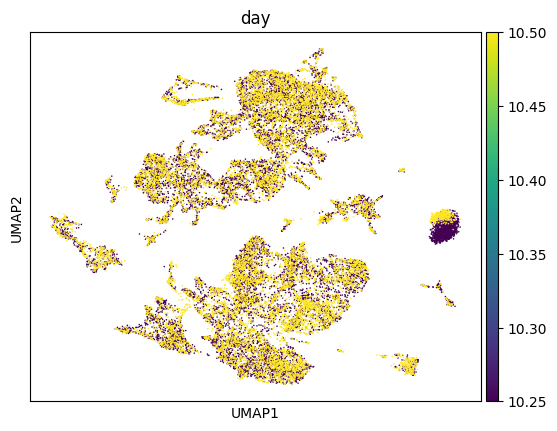

In [57]:
adata_concat = sc.concat(
    [adata[adata.obs.day==10.25], adata[adata.obs.day==10.5]],
)  
adata_concat.obsm["X_new"] = np.concatenate(
    (np.array(result_forward), adata[adata.obs.day==10.5].obsm['X_emb']),
    axis=0
)
#del adata_concat.obsm['X_diffmap']

sc.pp.neighbors(adata_concat, use_rep='X_new')
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color='day')

# 4x

In [34]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata[adata.obs.day==10.25].obsm['X_emb'], adata[adata.obs.day==10.5].obsm['X_emb']
          ).divergence

Array(8.932709, dtype=float32)

In [35]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata_concat[adata_concat.obs.day==10.25].obsm['X_new'], adata_concat[adata_concat.obs.day==10.5].obsm['X_new']
          ).divergence

Array(11.048603, dtype=float32)

# 8x

In [42]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata[adata.obs.day==10.25].obsm['X_emb'], adata[adata.obs.day==10.5].obsm['X_emb']
          ).divergence

Array(9.110973, dtype=float32)

In [43]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata_concat[adata_concat.obs.day==10.25].obsm['X_new'], adata_concat[adata_concat.obs.day==10.5].obsm['X_new']
          ).divergence

Array(10.396938, dtype=float32)

# 16x

In [50]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata[adata.obs.day==10.25].obsm['X_emb'], adata[adata.obs.day==10.5].obsm['X_emb']
          ).divergence

Array(9.49704, dtype=float32)

In [51]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata_concat[adata_concat.obs.day==10.25].obsm['X_new'], adata_concat[adata_concat.obs.day==10.5].obsm['X_new']
          ).divergence

Array(10.448196, dtype=float32)

# 32x

In [58]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata[adata.obs.day==10.25].obsm['X_emb'], adata[adata.obs.day==10.5].obsm['X_emb']
          ).divergence

Array(10.36409, dtype=float32)

In [59]:
sinkhorn_divergence.sinkhorn_divergence(
              pointcloud.PointCloud, adata_concat[adata_concat.obs.day==10.25].obsm['X_new'], adata_concat[adata_concat.obs.day==10.5].obsm['X_new']
          ).divergence

Array(10.935513, dtype=float32)

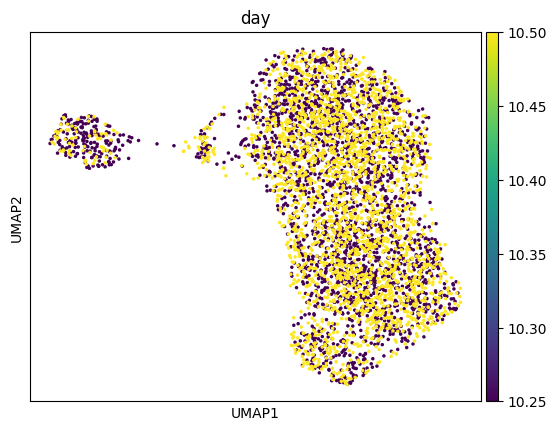

In [37]:
adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/training/100k/2k_genes/integrated_adata.h5ad')
adata = adata[[x in [10.5, 10.25] for x in adata.obs.day]]
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata, color='day')

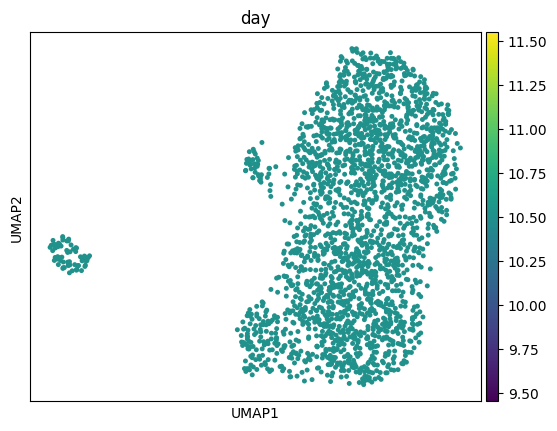

In [30]:
adata = sc.read_h5ad('/home/icb/jonas.flor/gastrulation_atlas/scvi/training/100k/2k_genes/integrated_adata.h5ad')
adata = adata[[x in [10.5] for x in adata.obs.day]]
sc.pp.neighbors(adata, use_rep='X_emb')
sc.tl.umap(adata)
sc.pl.umap(adata, color='day')

In [36]:
adata_concat.write('push_target.h5ad')

In [39]:
adata.obs.day.unique()

array([10.25, 10.5 ])

In [40]:
adata.write('source_target.h5ad')